In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pandas.plotting import table
from scipy.optimize import minimize

In [8]:
data = pd.read_csv("E:/Projects/AGN_mass_project/data/cassianiga_2013.csv")
data = data.loc[:]

In [9]:
# First we will fit the linear model on these alpha and beta values and observe error in the model, and later we optimize the values to minimize that error

Hβ_alpha_beta_list = [(0.672,0.61,'MD04'),                      # First tuple= By Mclure Dunlop (MD04)
                      (0.91,0.5,'VP06'),                        # second tuple= By Vestergaard & Peterson 2006 (VP06)
                      (1.63,0.49,'S11')]                       # Third tuple= By Shaw 2012 

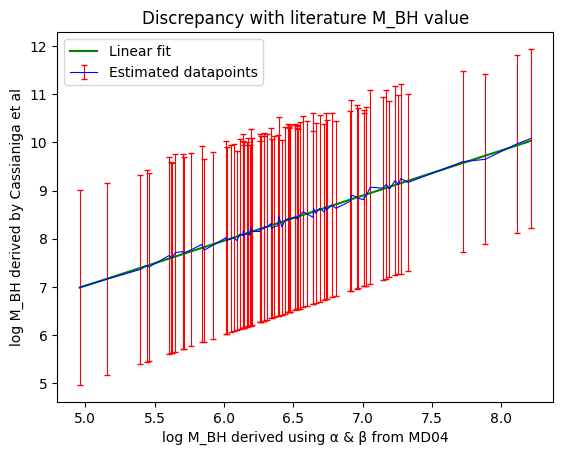

     This_work  Cassianiga_2013  Difference
121     4.9604             6.99      2.0296
16      5.1607             7.16      1.9993
21      5.3986             7.36      1.9614
40      5.4424             7.44      1.9976
151     5.4596             7.41      1.9504
..         ...              ...         ...
68      7.3286             9.17      1.8414
34      7.7212             9.60      1.8788
108     7.8834             9.65      1.7666
43      8.1110             9.97      1.8590
139     8.2110            10.08      1.8690

[84 rows x 3 columns]
Mean error in predictions before optimization: 1.9295416666666678


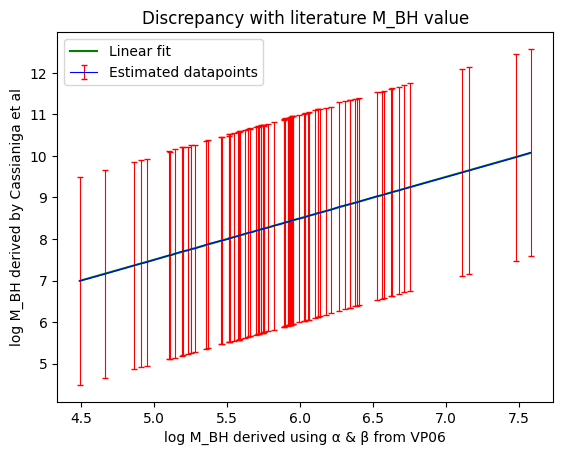

     This_work  Cassianiga_2013  Difference
121      4.490             6.99       2.500
16       4.665             7.16       2.495
21       4.860             7.36       2.500
151      4.910             7.41       2.500
40       4.950             7.44       2.490
..         ...              ...         ...
72       6.755             9.25       2.495
34       7.110             9.60       2.490
108      7.160             9.65       2.490
43       7.480             9.97       2.490
139      7.580            10.08       2.500

[84 rows x 3 columns]
Mean error in predictions before optimization: 2.49827380952381


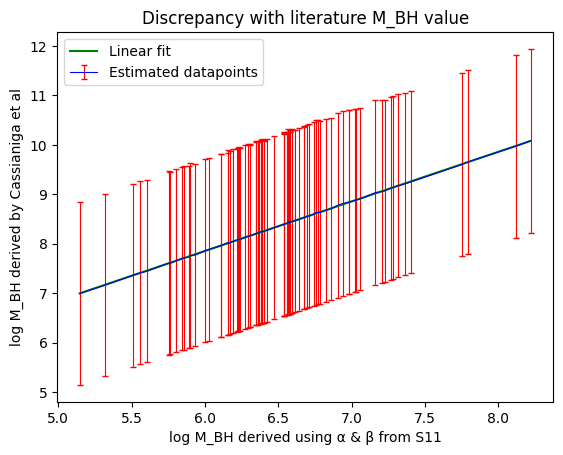

     This_work  Cassianiga_2013  Difference
121     5.1456             6.99      1.8444
16      5.3183             7.16      1.8417
21      5.5094             7.36      1.8506
151     5.5584             7.41      1.8516
40      5.6036             7.44      1.8364
..         ...              ...         ...
72      7.4061             9.25      1.8439
34      7.7528             9.60      1.8472
108     7.7926             9.65      1.8574
43      8.1210             9.97      1.8490
139     8.2210            10.08      1.8590

[84 rows x 3 columns]
Mean error in predictions before optimization: 1.851613095238096
Optimal alpha and beta values are: [3.42364646 0.49790406]


In [10]:
for i in range(len(Hβ_alpha_beta_list)):
    alpha= Hβ_alpha_beta_list[i][0]
    beta= Hβ_alpha_beta_list[i][1]
    alpha_beta_taken_from = Hβ_alpha_beta_list[i][2]   
    gamma = 2
    df = pd.DataFrame({'L': data['logL51'], 'FWHM': data['logWHb']})   


    df['L'] = pd.to_numeric(df['L'], errors='coerce')
    df['FWHM'] = pd.to_numeric(df['FWHM'], errors='coerce')
    df = df.dropna(subset=['L', 'FWHM'])
    L = 7+ df['L']                                                     # Here also the unit of the data is given as 10^-7, just like Shaw et al. So we converted it to erg/s.
    FWHM = 10**(df['FWHM'])                                        # Here we needed to convert log (WHb) into WHb, so we did 10^(logWHb)


    def log_M_BH(alpha,beta,gamma,L,FWHM):      
        return alpha + np.log10(10**L/1e44)*beta + np.log10(FWHM/1000)*gamma    # As L values were originally in log, we took antilog here by doing 10^L


    log_M_BH_array = np.zeros(len(L))
    for index,value in enumerate(log_M_BH(alpha,beta,gamma,L,FWHM)):       
        log_M_BH_array[index]= value                                           


    plot_df = pd.DataFrame({'This_work': log_M_BH_array, 'Cassianiga_2013': data['logMHb'][df.index].astype(float)})  
    plot_df = plot_df.sort_values(['This_work', 'Cassianiga_2013'], ascending=[True, True])
    y_err = abs(plot_df['Cassianiga_2013']-plot_df['This_work'])


    result = stats.linregress(plot_df['This_work'],plot_df['Cassianiga_2013'])    # Linear fitting model


    plt.xlabel(f'log M_BH derived using α & β from {alpha_beta_taken_from}')
    plt.ylabel('log M_BH derived by Cassianiga et al')
    plt.title('Discrepancy with literature M_BH value')
    plt.errorbar(x=plot_df['This_work'], y=plot_df['Cassianiga_2013'], yerr=y_err,color='blue', ecolor='red',lw=0.8,capsize=2,label='Estimated datapoints')
    plt.plot(plot_df['This_work'], result.intercept + result.slope* plot_df['This_work'], color='green',label= 'Linear fit')
    plt.legend()
    plt.show()


    # From here we will optimize the values of alpha and beta to minimize the error in our calculated value and the actual value in literature
 
    observed_values = plot_df['Cassianiga_2013'] 
    def error(params):
        alpha, beta = params
        calculated_values = alpha + np.log10((10**L / 1e44)) * beta + np.log10(FWHM / 1000) * gamma

        return np.sum((sorted(calculated_values)-observed_values)**2)

    initial_guess = [0.5, 0.5]
    optimized_alpha_beta = minimize(error, initial_guess, method='Nelder-Mead')


    
    plot_df['Difference'] = y_err                                          # This part is just for printing the table
    table_df = plot_df[['This_work', 'Cassianiga_2013','Difference']]
    print(table_df)
    print('Mean error in predictions before optimization: '+str(np.mean(plot_df['Difference'])))

print("Optimal alpha and beta values are:", optimized_alpha_beta.x) 

OPTIMIZATION FIT

Hence, we now have obtained the optimal alpha and beta values. Now we plug in these values and form a new linear fit model to observe the minimization of error. (Changes in the above code to make the code below are written in comments)

In [11]:
alpha= optimized_alpha_beta.x[0]     # We will now fit the model with these optimal values of alpha and beta we got above
beta= optimized_alpha_beta.x[1]      
print(alpha,beta)

3.4236464595144644 0.49790405507097873


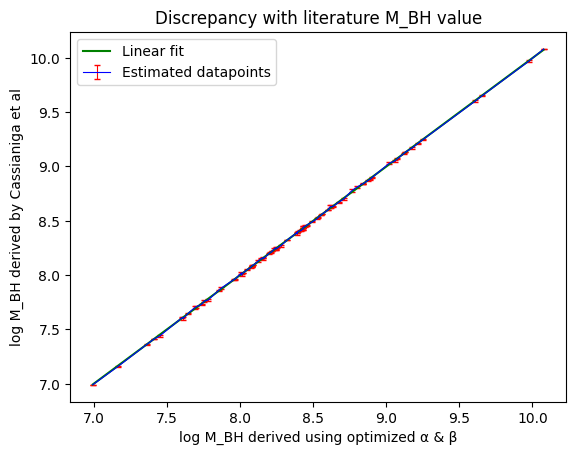

     M_BH using optimized parameters  Cassianiga_2013  Difference
121                         6.990149             6.99    0.000149
16                          7.164667             7.16    0.004667
21                          7.358849             7.36    0.001151
151                         7.408639             7.41    0.001361
40                          7.449729             7.44    0.009729
..                               ...              ...         ...
72                          9.254205             9.25    0.004205
34                          9.607466             9.60    0.007466
108                         9.655328             9.65    0.005328
43                          9.977088             9.97    0.007088
139                        10.077088            10.08    0.002912

[84 rows x 3 columns]
Mean error in predictions after using optimized alpha and beta: 0.005351043629008141


In [12]:
gamma = 2
df = pd.DataFrame({'L': data['logL51'], 'FWHM': data['logWHb']})   


df['L'] = pd.to_numeric(df['L'], errors='coerce')
df['FWHM'] = pd.to_numeric(df['FWHM'], errors='coerce')
df = df.dropna(subset=['L', 'FWHM'])
L = 7+ df['L']                                                     
FWHM = 10**(df['FWHM'])                                        


def log_M_BH(alpha,beta,gamma,L,FWHM):      
    return alpha + np.log10(10**L/1e44)*beta + np.log10(FWHM/1000)*gamma   


log_M_BH_array = np.zeros(len(L))
for index,value in enumerate(log_M_BH(alpha,beta,gamma,L,FWHM)):  
    log_M_BH_array[index]= value


plot_df = pd.DataFrame({'M_BH using optimized parameters': log_M_BH_array, 'Cassianiga_2013': data['logMHb'][df.index].astype(float)})# changed plot_df first column name everywhere
plot_df = plot_df.sort_values(['M_BH using optimized parameters', 'Cassianiga_2013'], ascending=[True, True])
y_err = abs(plot_df['Cassianiga_2013']-plot_df['M_BH using optimized parameters'])

result = stats.linregress(plot_df['M_BH using optimized parameters'],plot_df['Cassianiga_2013'])


plt.xlabel('log M_BH derived using optimized α & β')       # changed the xlabel
plt.ylabel('log M_BH derived by Cassianiga et al')
plt.title('Discrepancy with literature M_BH value')
plt.errorbar(x=plot_df['M_BH using optimized parameters'], y=plot_df['Cassianiga_2013'], yerr=y_err,color='blue', ecolor='red',lw=0.8,capsize=2,label='Estimated datapoints')
plt.plot(plot_df['M_BH using optimized parameters'], result.intercept + result.slope* plot_df['M_BH using optimized parameters'], color='green',label= 'Linear fit')
plt.legend()
plt.show()


plot_df['Difference'] = y_err
table_df = plot_df[['M_BH using optimized parameters', 'Cassianiga_2013','Difference']]
print(table_df)
print('Mean error in predictions after using optimized alpha and beta: '+str(np.mean(plot_df['Difference']))) # changed the print 